# Setup Code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import torch.nn.functional as F
import numpy as np
import sys
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
# select devices
DEVICE = None
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Bad to go!")
    DEVICE = torch.device("cpu")

Good to go!


Load config from config files.

In [4]:
# load config
sys.path.append(os.getcwd())
# choose between ship, lego
import configs.ship, configs.lego
sample_t: tuple = (2,6)
scale_factor = 2
# change config file here
config = configs.lego

Load the dataset and show the first one.

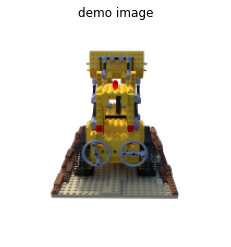

and its pose: 
[[-9.99902189e-01  4.19224519e-03 -1.33457193e-02 -5.37983216e-02]
 [-1.39886811e-02 -2.99659073e-01  9.53943670e-01  3.84547043e+00]
 [-4.65661287e-10  9.54037189e-01  2.99688309e-01  1.20808232e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [5]:
from nerf.data import load_blender
imgs, poses, int_mat = load_blender(config.datadir, device="cpu", scale_factor=scale_factor)
img_n, img_h, img_w = imgs.shape[:3]
# visualize
plt.imshow(np.array(imgs[0].to(device="cpu")))
plt.axis("off")
plt.title("demo image")
plt.show()
print("and its pose: ")
print(np.array(poses[0].to(device="cpu")))

# Test Functions

In [6]:
# compute rays
from nerf.graphics import compute_rays

rays_o, rays_d = compute_rays((img_h, img_w), int_mat, poses[0])
print("origin: ", rays_o[0,0])
print("normalized origin: ", F.normalize(rays_o[0,0], dim=0))
print("center of ray: ", rays_d[img_h//2,img_w//2])

origin:  tensor([-0.0538,  3.8455,  1.2081], dtype=torch.float64)
normalized origin:  tensor([-0.0133,  0.9539,  0.2997], dtype=torch.float64)
center of ray:  tensor([ 0.0133, -0.9539, -0.2997], dtype=torch.float64)


In [7]:
# query from rays
from nerf.graphics import queries_from_rays
samples = None
samples, depths = queries_from_rays(rays_o, rays_d, sample_t, 8)
print("samples[0, 0]: ", samples[0,0])
print("depths: ", depths)

samples[0, 0]:  tensor([[ 0.7020,  1.7145,  1.2963],
        [ 0.9102,  1.1274,  1.3206],
        [ 1.2683,  0.1180,  1.3625],
        [ 1.4243, -0.3219,  1.3807],
        [ 1.5995, -0.8158,  1.4011],
        [ 1.8413, -1.4975,  1.4294],
        [ 2.0507, -2.0882,  1.4538],
        [ 2.3411, -2.9069,  1.4877]], dtype=torch.float64)
depths:  tensor([[[2.0165, 2.5720, 3.5272,  ..., 5.0559, 5.6148, 6.3896],
         [2.3756, 3.0501, 3.3953,  ..., 5.0336, 5.8415, 6.4643],
         [2.2288, 2.5880, 3.2523,  ..., 5.2378, 5.7156, 6.2294],
         ...,
         [2.4910, 2.6583, 3.1939,  ..., 5.2298, 5.7192, 6.0558],
         [2.4509, 3.0006, 3.2916,  ..., 4.8772, 5.6990, 6.3188],
         [2.2082, 2.6551, 3.2383,  ..., 5.3262, 5.7499, 6.0382]],

        [[2.3144, 2.8275, 3.5487,  ..., 5.2744, 5.5995, 6.3040],
         [2.2096, 2.5928, 3.5916,  ..., 5.1783, 5.7707, 6.2471],
         [2.2747, 2.9140, 3.1755,  ..., 5.3555, 5.8752, 6.2316],
         ...,
         [2.3961, 2.9326, 3.2558,  ..., 5.

In [8]:
# test pos encode

from nerf.nerf_helper import *

L = 6
x = torch.tensor([[ 1.8013, -0.6242,  0.7009]])
# x = torch.tensor([ 1.8013, -0.6242,  0.7009])
enc_x = PosEncode(x, L, True)
# enc_xx = PosEncode1(x, L, True)
print(enc_x)
# print(enc_xx)




tensor([[ 1.8013,  0.9736, -0.2285, -0.4449, -0.8956,  0.7968,  0.6042,  0.9629,
         -0.2698, -0.5197, -0.8544,  0.8880,  0.4599, -0.6242, -0.5844,  0.8114,
         -0.9485,  0.3168, -0.6010, -0.7992,  0.9607,  0.2775,  0.5332, -0.8460,
         -0.9022,  0.4313,  0.7009,  0.6449,  0.7643,  0.9858,  0.1682,  0.3316,
         -0.9434, -0.6257,  0.7801, -0.9762,  0.2171, -0.4238, -0.9057]])


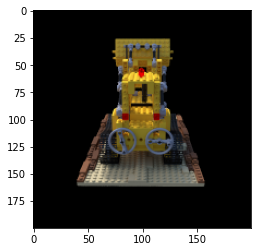

In [9]:
# test render from nerf
from nerf.graphics import render_from_nerf
fake_depth = torch.Tensor([1])
fake_nerf_output = imgs[0].cpu().reshape(img_h, img_w, 1, 4)
rgb, depth = render_from_nerf(fake_nerf_output, fake_depth)
plt.imshow(rgb)
plt.show()

# Train

In [10]:
# One iteration of TinyNeRF (forward pass).
# TODO train
# raise Exception("nothing wrong")


In [11]:
from nerf.model import NeRF, TinyNeRF
import os.path

###### parameters
L_pos = 10
L_dir = 4

num_samples = 32
batch_size = 4096 # increase batchsize if u have large GPU MEM
fc_width = 128
fc_depth = 4
skips = [2]

lr = 5e-4
# betas=(0.9, 0.999)
num_it = 10000
display_every = 200

###### models
model = NeRF(ch_in_pos=6*L_pos+3, ch_in_dir=6*L_dir+3, fc_width=fc_width, fc_depth=fc_depth, skips=skips)
# model = TinyNeRF(6*L_pos+3, fc_width=128)
model.to(DEVICE)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr,
    # betas=betas,
)
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)
ckpt_path = 'nerf.pt'


###### load validation data
imgs_val, poses_val, int_mat_val = load_blender(config.datadir, data_type="val",scale_factor=2, device="cpu")
num_val = imgs_val.shape[0]
# val_idx = 1
# val_img = imgs[val_idx].to(DEVICE)
# val_c2w = poses[val_idx]

###### train
psnrs = []
its = []
i = 0

###### check saved checkpoints
if os.path.exists(ckpt_path):
    print("checkpoint found! Loading...")
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    i = checkpoint['epoch']
    loss = checkpoint['loss']
    psnrs = checkpoint['psnrs']
    its = checkpoint['its']
    print("checkpoint loaded, i =",i)
else:
    print("No checkpoint found")

checkpoint found! Loading...
checkpoint loaded, i = 400


In [12]:
def train_one_step():
    gt_img_idx = np.random.randint(100)
    gt_img = imgs[gt_img_idx].clone().to(DEVICE)
    gt_c2w = poses[gt_img_idx].clone().to(DEVICE)

    optimizer.zero_grad()
    pred_rgb,_ = nerf_iter_once(
                model,
                (img_h, img_w),
                int_mat.to(DEVICE),
                gt_c2w,
                sample_t,
                L_pos,
                L_dir,
                num_samples=num_samples,
                batch_size=batch_size
                )
    loss = torch.nn.functional.mse_loss(pred_rgb, gt_img[...,:3])

    # print("train_it:", i, "img_idx: ", gt_img_idx, "loss:",float(loss))
    loss.backward()
    optimizer.step()


def val_one_step(i):
	val_idx = np.random.randint(num_val)
	val_img = imgs_val[val_idx].clone().to(DEVICE)
	val_c2w = poses_val[val_idx].clone().to(DEVICE)

	pred_rgb,_ = nerf_iter_once(
			model,
			(img_h, img_w),
			int_mat_val.to(DEVICE),
			val_c2w,
			sample_t,
			L_pos,
			L_dir,
			num_samples=num_samples,
			batch_size=batch_size
			)

	loss = torch.nn.functional.mse_loss(pred_rgb, val_img[...,:3])
	print("Iteration ", i)
	print("Val loss: ", loss)

	psnr = -10. * torch.log10(loss)
	psnrs.append(psnr.item())
	its.append(i)

	plt.figure(figsize=(10, 4))
	plt.subplot(121)
	img_np = pred_rgb.detach().cpu().numpy()
	plt.imshow(img_np)
	plt.title(f"Iteration {i}")
	plt.subplot(122)
	plt.plot(its, psnrs)
	plt.title("PSNR")
	plt.show()

	torch.save({
		'epoch': i,
		'model_state_dict': model.state_dict(),
		'optimizer_state_dict': optimizer.state_dict(),
		'loss': loss,
		'psnrs': psnrs,
		'its': its}, ckpt_path)


  0%|                                                  | 0/9600 [00:00<?, ?it/s]

Iteration  400
Val loss:  tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)


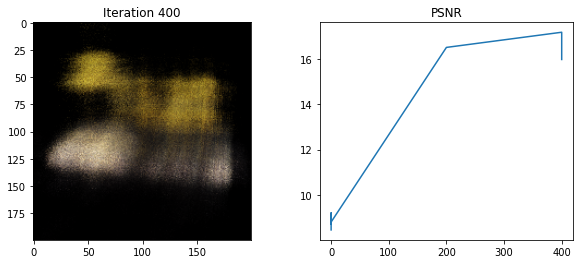

  2%|▊                                       | 200/9600 [00:59<48:26,  3.23it/s]

Iteration  600
Val loss:  tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)


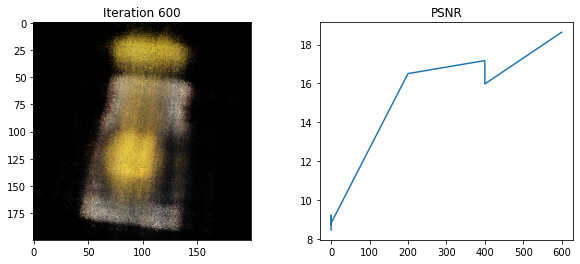

  4%|█▋                                      | 400/9600 [01:59<46:38,  3.29it/s]

Iteration  800
Val loss:  tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)


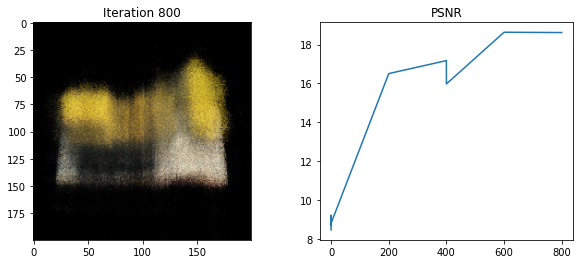

  6%|██▌                                     | 600/9600 [02:57<45:50,  3.27it/s]

Iteration  1000
Val loss:  tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)


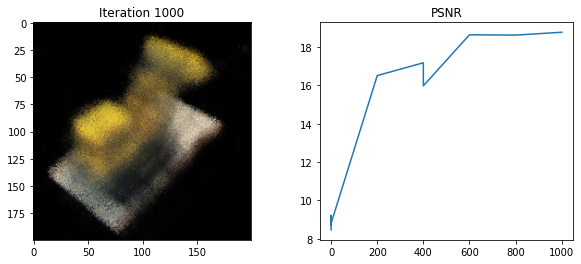

  8%|███▎                                    | 800/9600 [03:55<41:59,  3.49it/s]

Iteration  1200
Val loss:  tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)


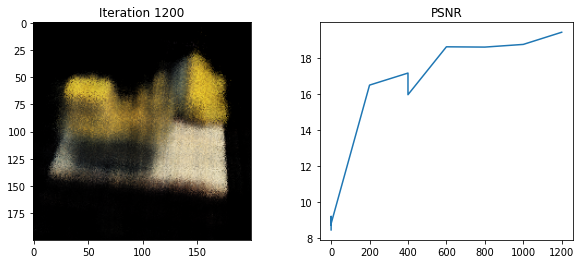

 10%|████                                   | 1000/9600 [04:54<41:04,  3.49it/s]

Iteration  1400
Val loss:  tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)


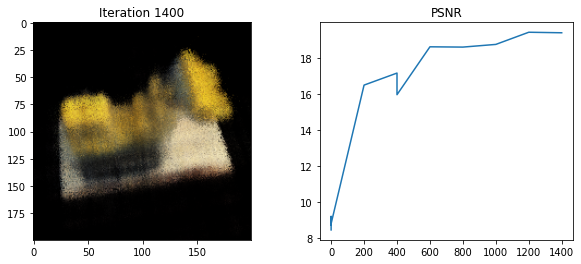

 12%|████▉                                  | 1200/9600 [05:54<40:22,  3.47it/s]

Iteration  1600
Val loss:  tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)


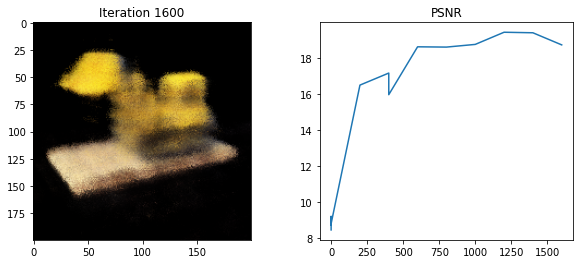

 15%|█████▋                                 | 1400/9600 [06:52<39:17,  3.48it/s]

Iteration  1800
Val loss:  tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward0>)


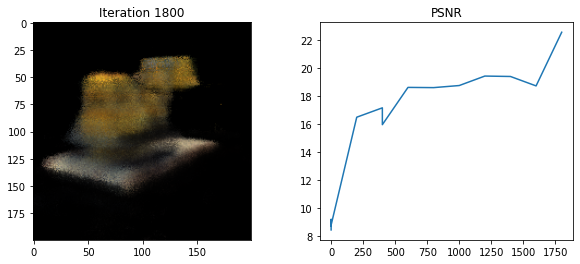

 17%|██████▌                                | 1600/9600 [07:51<38:44,  3.44it/s]

Iteration  2000
Val loss:  tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward0>)


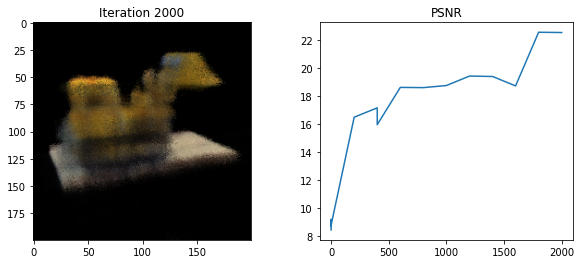

 19%|███████▎                               | 1800/9600 [08:50<38:18,  3.39it/s]

Iteration  2200
Val loss:  tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)


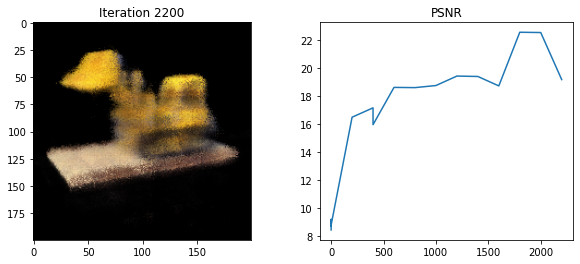

 21%|████████▏                              | 2000/9600 [09:49<36:22,  3.48it/s]

Iteration  2400
Val loss:  tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)


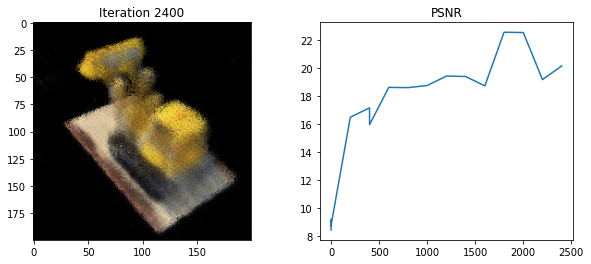

 23%|████████▉                              | 2200/9600 [10:47<36:30,  3.38it/s]

Iteration  2600
Val loss:  tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)


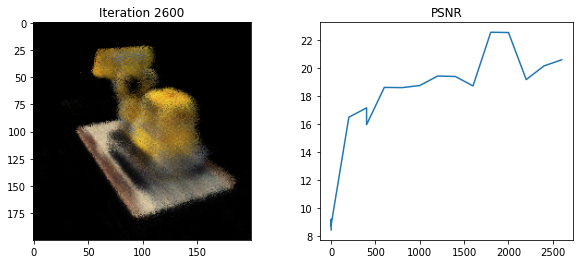

 25%|█████████▊                             | 2400/9600 [11:46<35:44,  3.36it/s]

Iteration  2800
Val loss:  tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward0>)


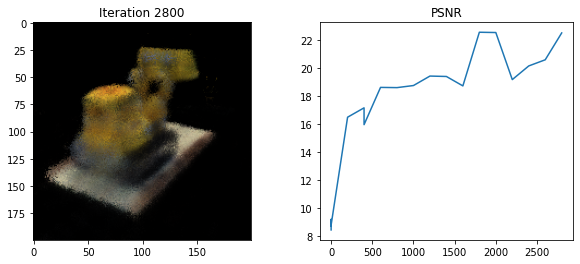

 27%|██████████▌                            | 2600/9600 [12:45<33:24,  3.49it/s]

Iteration  3000
Val loss:  tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)


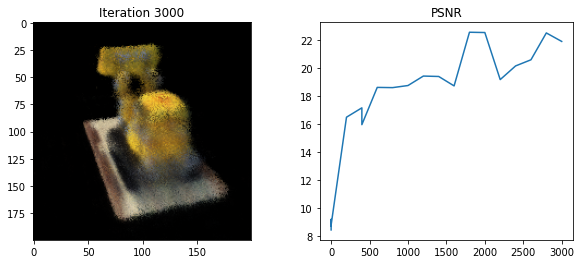

 29%|███████████▍                           | 2800/9600 [13:43<33:36,  3.37it/s]

Iteration  3200
Val loss:  tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward0>)


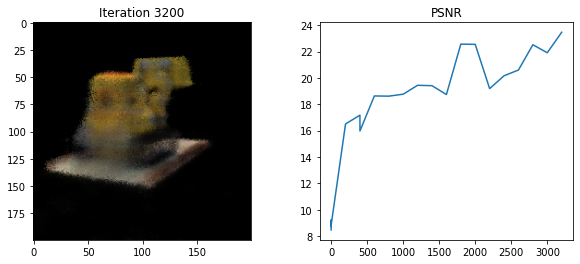

 31%|████████████▏                          | 3000/9600 [14:42<32:06,  3.43it/s]

Iteration  3400
Val loss:  tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)


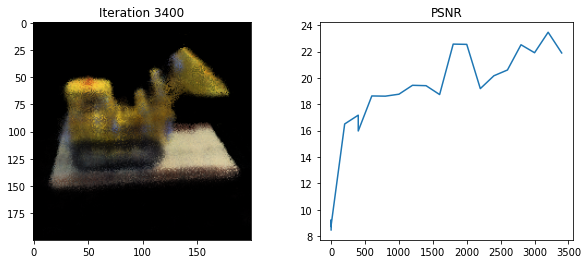

 33%|█████████████                          | 3200/9600 [15:41<31:31,  3.38it/s]

Iteration  3600
Val loss:  tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)


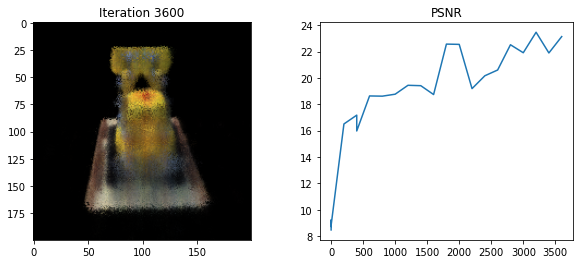

 35%|█████████████▊                         | 3400/9600 [16:39<29:36,  3.49it/s]

Iteration  3800
Val loss:  tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)


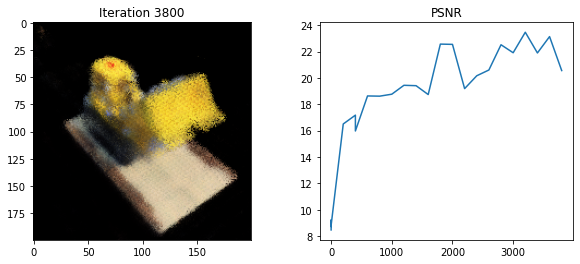

 38%|██████████████▋                        | 3600/9600 [17:38<30:40,  3.26it/s]

Iteration  4000
Val loss:  tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)


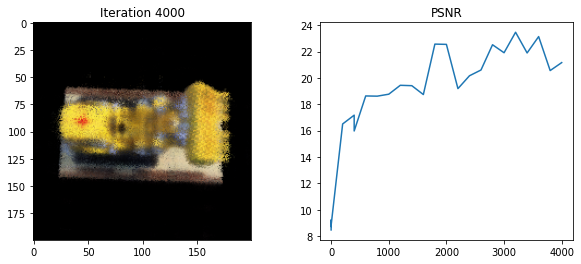

 40%|███████████████▍                       | 3800/9600 [18:37<28:30,  3.39it/s]

Iteration  4200
Val loss:  tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)


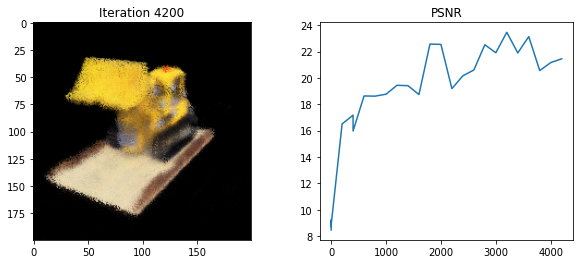

 42%|████████████████▎                      | 4000/9600 [19:36<27:01,  3.45it/s]

Iteration  4400
Val loss:  tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)


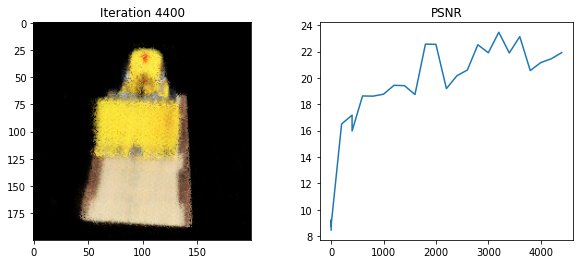

 44%|█████████████████                      | 4200/9600 [20:35<25:46,  3.49it/s]

Iteration  4600
Val loss:  tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)


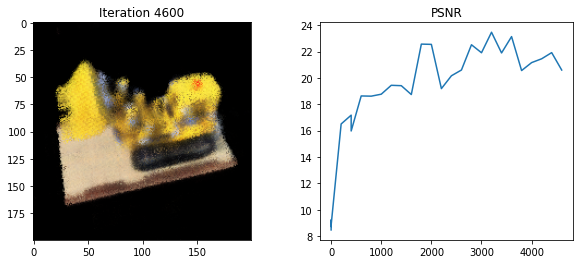

 46%|█████████████████▉                     | 4400/9600 [21:33<25:28,  3.40it/s]

Iteration  4800
Val loss:  tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)


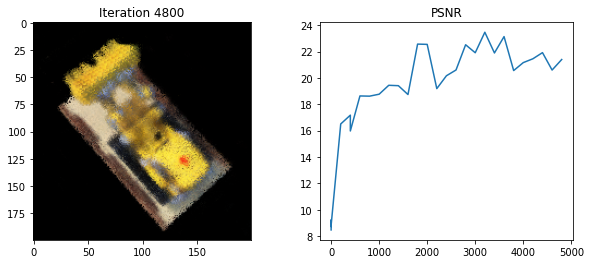

 48%|██████████████████▋                    | 4600/9600 [22:31<24:44,  3.37it/s]

Iteration  5000
Val loss:  tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward0>)


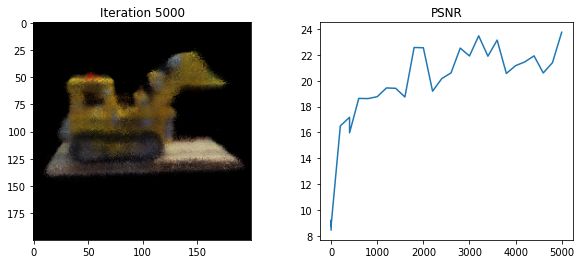

 50%|███████████████████▌                   | 4800/9600 [23:29<22:54,  3.49it/s]

Iteration  5200
Val loss:  tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)


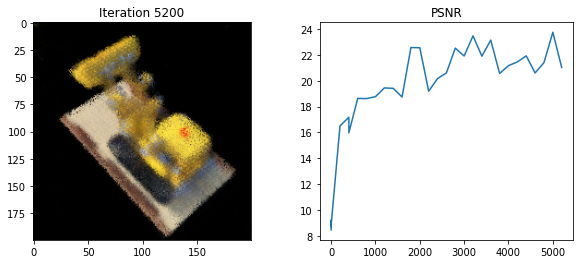

 52%|████████████████████▎                  | 5000/9600 [24:26<21:58,  3.49it/s]

Iteration  5400
Val loss:  tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)


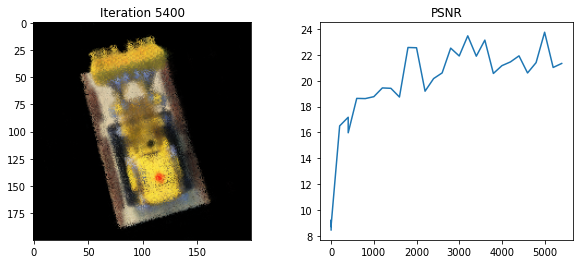

 54%|█████████████████████▏                 | 5200/9600 [25:25<21:00,  3.49it/s]

Iteration  5600
Val loss:  tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)


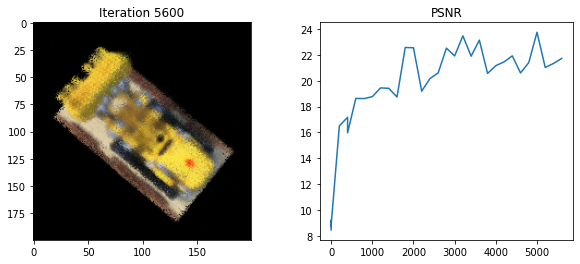

 56%|█████████████████████▉                 | 5400/9600 [26:22<20:03,  3.49it/s]

Iteration  5800
Val loss:  tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)


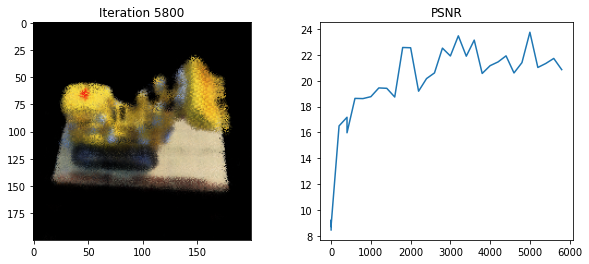

 58%|██████████████████████▊                | 5600/9600 [27:22<19:11,  3.47it/s]

Iteration  6000
Val loss:  tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)


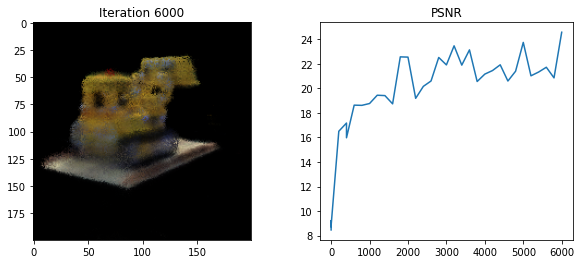

 60%|███████████████████████▌               | 5800/9600 [28:20<18:17,  3.46it/s]

Iteration  6200
Val loss:  tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)


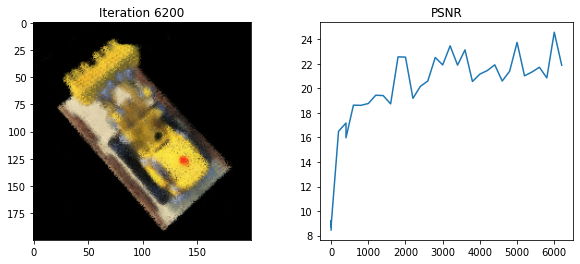

 62%|████████████████████████▍              | 6000/9600 [29:18<17:21,  3.46it/s]

Iteration  6400
Val loss:  tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward0>)


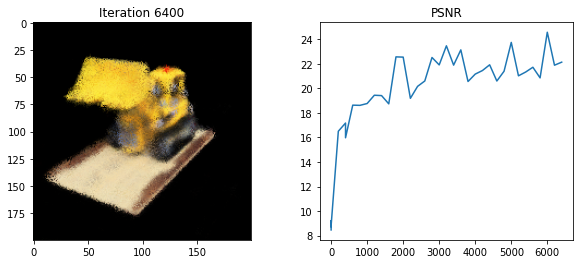

 65%|█████████████████████████▏             | 6200/9600 [30:16<16:14,  3.49it/s]

Iteration  6600
Val loss:  tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)


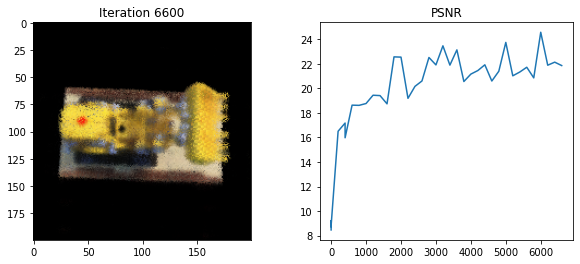

 67%|██████████████████████████             | 6400/9600 [31:15<16:11,  3.29it/s]

Iteration  6800
Val loss:  tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)


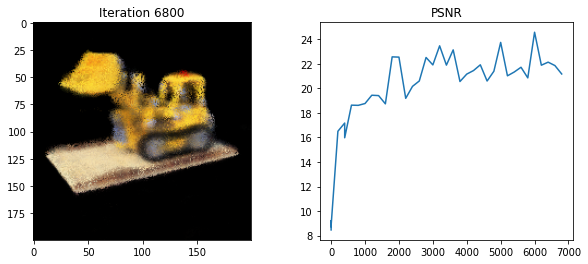

 69%|██████████████████████████▊            | 6600/9600 [32:14<14:34,  3.43it/s]

Iteration  7000
Val loss:  tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)


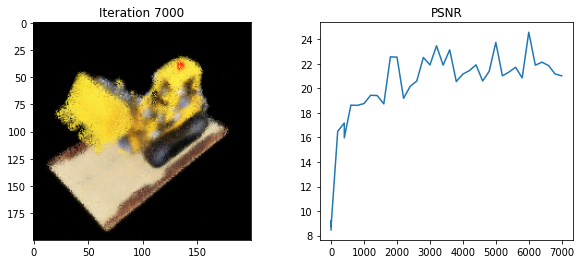

 71%|███████████████████████████▋           | 6800/9600 [33:13<13:26,  3.47it/s]

Iteration  7200
Val loss:  tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)


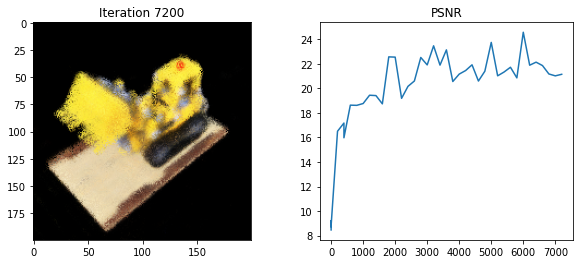

 73%|████████████████████████████▍          | 7000/9600 [34:12<12:34,  3.44it/s]

Iteration  7400
Val loss:  tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)


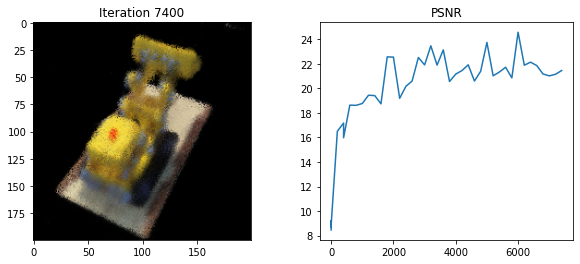

 75%|█████████████████████████████▎         | 7200/9600 [35:10<11:58,  3.34it/s]

Iteration  7600
Val loss:  tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)


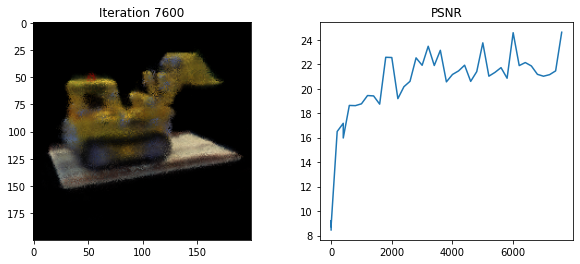

 76%|█████████████████████████████▌         | 7289/9600 [35:36<11:02,  3.49it/s]

In [ ]:
for i in tqdm(range(i, num_it)):
    if i % display_every == 0:
        val_one_step(i)
    else:
        train_one_step()